In [2]:
# Muhsin Ciftci, Data Analysis

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from textblob import TextBlob

import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
plt.style.use('gadfly_theme')

In [3]:
stops_eng = set(stopwords.words('english'))
stops_eng.add('rt') #remove rt for retweets

In [91]:
#! pip install textblob

# 0. Download Data

In [9]:
df_april = pd.read_json('April22_clean.json', convert_axes=False, dtype=False)
#df_april = pd.read_csv('april22', dtype = {'id':str, 'author_id':str, 'in_reply_to_user_id':str})

df_may  = pd.read_json('May5_clean.json', convert_axes=False, dtype=False)
df_june = pd.read_json('June1_clean.json', convert_axes=False, dtype=False)

In [10]:
df_april.head(5) # Use text_clean_sentiment column

,id,text,created_at,author_id,in_reply_to_user_id,author,entities,referenced_tweets,media,text_clean_sentiment,text_clean,hashtags,Hostile_JD,Hostile_AH,Support_JD,Supprt_AH
0,1517654229258756097,RT @TimRunsHisMouth: Johnny Depp defamation ca...,2022-04-22 23:58:59+00:00,1298590735697158144,NaN,NaN,NaN,"[{""type"":""retweeted"",""id"":""1517593782165942272""}]",NaN,johnny depp defamation case walltowall nonstop...,johnny depp defamation case walltowall nonsto...,NaN,0,0,0,0
1,1517654226951938054,RT @roaringrapids22: #JohnnyDepp is one of the...,2022-04-22 23:58:59+00:00,1470458047831097347,NaN,NaN,NaN,"[{""type"":""retweeted"",""id"":""1517572440708243458""}]",NaN,johnnydepp one 1 4 men abusive relationship on...,johnnydepp is one of the 1 in 4 men that have...,NaN,0,0,0,0
2,1517654225169399808,RT @danblock4: Bredehoft: ‘This is what she us...,2022-04-22 23:58:58+00:00,1282534162352807936,NaN,NaN,NaN,"[{""type"":""retweeted"",""id"":""1517652619883335683""}]",NaN,bredehoft ‘ used cover bruises mixed different...,bredehoft ‘this is what she used to cover the...,NaN,0,0,0,0
3,1517654223252598785,RT @thevivafrei: If Amber Heard drank two bott...,2022-04-22 23:58:58+00:00,430257546,NaN,NaN,NaN,"[{""type"":""retweeted"",""id"":""1516790291335987207""}]",NaN,amber heard drank two bottles vega sicilia nig...,if amber heard drank two bottles of vega sicil...,NaN,0,0,0,0
4,1517654221503574019,RT @mculokii: johnny depp dealing with clown r...,2022-04-22 23:58:57+00:00,1016419603331903489,NaN,NaN,NaN,"[{""type"":""retweeted"",""id"":""1517264786290974720""}]",NaN,johnny depp dealing clown rottenborn day 7 cou...,johnny depp dealing with clown rottenborn at d...,NaN,0,0,0,0


# 1. Check Tweets across Languages

In [125]:
## FROM OLD DATA, DOES NOT MATTER FOR LANGUAGE CLASSIFICATION
# NEW DATA DOES NOT HAVE OTHER LANGUAGES
df_april_2 = pd.read_csv('april22', dtype = {'id':str, 'author_id':str, 'in_reply_to_user_id':str})
df_may_2   = pd.read_csv('april22', dtype = {'id':str, 'author_id':str, 'in_reply_to_user_id':str})
df_june_2  = pd.read_csv('april22', dtype = {'id':str, 'author_id':str, 'in_reply_to_user_id':str})

df_lang_april = df_april_2.groupby('lang')['lang'].value_counts().sort_values(ascending=False)
df_lang_may   = df_may_2.groupby('lang')['lang'].value_counts().sort_values(ascending=False)
df_lang_june  = df_june_2.groupby('lang')['lang'].value_counts().sort_values(ascending=False)

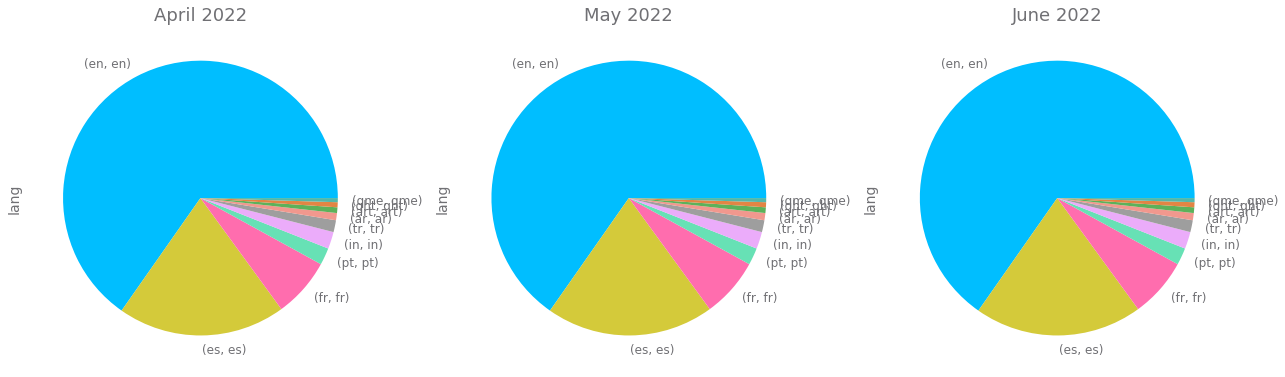

In [130]:
plt.figure(figsize = (18, 12))

plt.subplot(1, 3, 1)
df_lang_april.head(10).plot(kind = 'pie')
plt.title('April 2022')

plt.subplot(1, 3, 2)
df_lang_may.head(10).plot(kind = 'pie')
plt.title('May 2022')

plt.subplot(1, 3, 3)
df_lang_june.head(10).plot(kind = 'pie')
plt.title('June 2022')
plt.tight_layout()
plt.savefig('Charts/tweets_lang_pie.png')
plt.show()

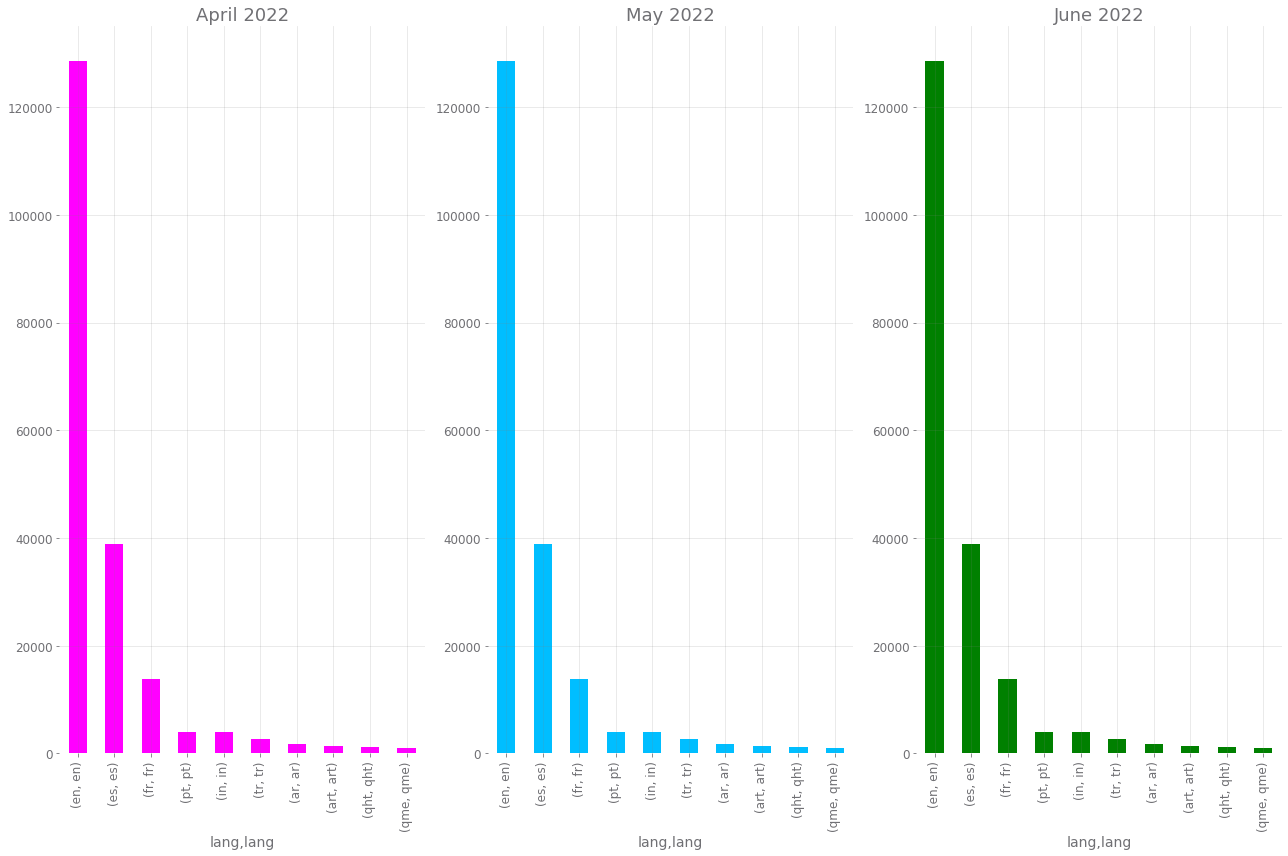

In [129]:
plt.figure(figsize = (18, 12))

plt.subplot(1, 3, 1)
df_lang_april.head(10).plot(kind = 'bar', color = 'magenta')
plt.title('April 2022')

plt.subplot(1, 3, 2)
df_lang_may.head(10).plot(kind = 'bar')
plt.title('May 2022')

plt.subplot(1, 3, 3)
df_lang_june.head(10).plot(kind = 'bar', color = 'green')
plt.title('June 2022')
plt.tight_layout()
plt.savefig('Charts/tweets_lang.png')
plt.show()

# 2. Sentiment, Using Hugging Face

## 2.1 Training Our Twitter Data 

In [122]:
# Open csv
import csv
file = open('april22')
csvapril = csv.reader(file)
month = ["april22", "maydata", "junefirst"]

#Sentiment analysis with the module TextBlob

# Create a classifier to analyze the polarity of each tweet
def analize_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
month = ["april22", "maydata", "junefirst"]
    
def textbob_all(tweet):
    with open(tweet) as f:
        reader = csv.reader(f, delimiter=',')
        next(reader)     
        text=[]
        for t in reader:    
            text.append(t[1])
        ana = []
        for tweet in text:
            ana.append(analize_sentiment(tweet)) # Create a new column with the result of sentiment analysis
        pos_tweet=[]
        neu_tweet=[]
        neg_tweet=[]
        for i,t in enumerate(text):
            if ana[i] > 0:
                pos_tweet.append(t) # List of positive tweets
            if ana[i] ==0:
                neu_tweet.append(t) # List of neutral tweets
            if ana[i] < 0:
                neg_tweet.append(t) # List of negative tweets
        
        return [round(len(pos_tweet)*100/len(text),2), # Ratio of positive tweets
                round(len(neu_tweet)*100/len(text),2),  # Ratio of neutral tweets
                round(len(neg_tweet)*100/len(text),2)] # Ratio of negative tweets

print("The polarity rate of tweets with sentiment analysis using the module TextBlob:\n")
print("Month:","[positive(%)]", "[neutral(%)]", "[negative(%)]\n")
for t in month:
    print({t: textbob_all(t)}, "\n")

The polarity rate of tweets with sentiment analysis using the module TextBlob:

Month: [positive(%)] [neutral(%)] [negative(%)]

{'april22': [14.93, 77.03, 8.04]} 

{'maydata': [23.79, 53.28, 22.93]} 

{'junefirst': [24.32, 63.96, 11.72]} 



In [13]:
# Visualize Sentiments
sent_data = pd.DataFrame(np.array([[14.93, 77.03, 8.04],
                                   [23.79, 53.28, 22.93],
                                   [24.32, 63.96, 11.72]]),
                         columns = ['Positive', 'Neutral', 'Negative'])
sent_data = sent_data.rename(index = {0: "April", 1: "May", 2: "June"})
sent_data

,Positive,Neutral,Negative
April,14.93,77.03,8.04
May,23.79,53.28,22.93
June,24.32,63.96,11.72


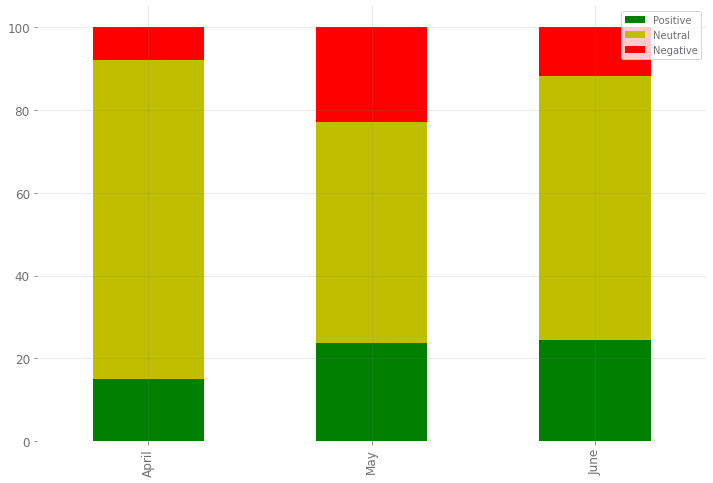

In [121]:
# Stacked Chart
#plt.figure(figsize = (10, 8))
sent_data.plot(kind = 'bar', stacked = True, color = ['g', 'y', 'r'], figsize = (12,8))
plt.savefig('Charts/stacked_sentiment.png')
plt.show()

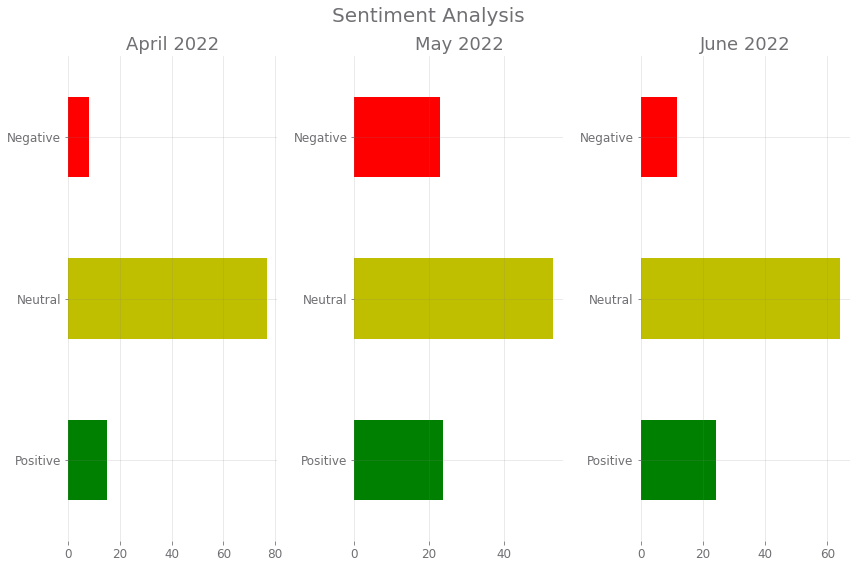

In [106]:
plt.figure(figsize = (12, 8))
plt.suptitle('Sentiment Analysis', size = 20)

plt.subplot(1, 3, 1)
sent_data.loc['April'].plot(kind = 'barh', color = ['g', 'y', 'r'])
plt.title('April 2022')

plt.subplot(1, 3, 2)
sent_data.loc['May'].plot(kind = 'barh', color = ['g', 'y', 'r'])
plt.title('May 2022')

plt.subplot(1, 3, 3)
sent_data.loc['June'].plot(kind = 'barh', color = ['g', 'y', 'r'])
plt.title('June 2022')
plt.tight_layout()
plt.savefig('Charts/tweets_sentiment.png')
plt.show()

# 3. Tweet Counts

In [20]:
words_in_tweet_april = [tweet.lower().split() for tweet in df_april.text_clean_sentiment]
words_in_tweet_may   = [tweet.lower().split() for tweet in df_may.text_clean_sentiment]
words_in_tweet_june  = [tweet.lower().split() for tweet in df_june.text_clean_sentiment]

In [21]:
# List of all words across tweets
all_words_april = list(itertools.chain(*words_in_tweet_april))
all_words_may   = list(itertools.chain(*words_in_tweet_may))
all_words_june  = list(itertools.chain(*words_in_tweet_june))

# Create counter
counts_no_april = collections.Counter(all_words_april)
counts_no_may   = collections.Counter(all_words_may)
counts_no_june  = collections.Counter(all_words_june)

In [39]:
final_april = pd.DataFrame(counts_no_april.most_common(10), columns=['words', 'count'])
final_april = final_april[final_april['words'].str.len() >= 2] # Clean "'"

final_may   = pd.DataFrame(counts_no_may.most_common(10), columns=['words', 'count'])
final_may   = final_may[final_may['words'].str.len() >= 2] # Clean "'"

final_june  = pd.DataFrame(counts_no_june.most_common(10), columns=['words', 'count'])
final_june  = final_june[final_june['words'].str.len() >= 2] # Clean "'"

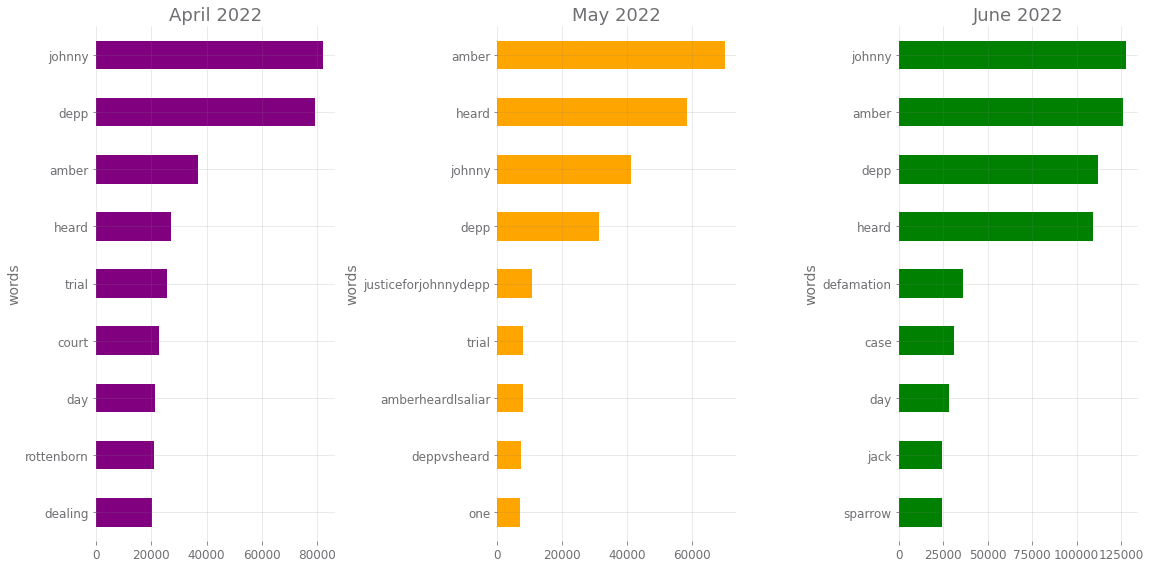

In [44]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(16, 8), nrows = 1, ncols=3)

plt.subplot(1, 3, 1)
final_april.sort_values(by = 'count').plot.barh(x = 'words', y = 'count', ax = ax1, color = "purple", legend = False)
ax1.set_title('April 2022')

plt.subplot(1, 3, 2)
final_may.sort_values(by = 'count').plot.barh(x = 'words', y = 'count', ax = ax2, color = "orange", legend = False)
ax2.set_title('May 2022')

plt.subplot(1, 3, 3)
final_june.sort_values(by = 'count').plot.barh(x = 'words', y = 'count', ax = ax3, color = "green", legend = False)
ax3.set_title('June 2022')

plt.tight_layout()
plt.savefig('Charts/tweet_word_counts')
plt.show()

## 2.2 Use Hugging Face

In [92]:
# Use This one
#from transformers import pipeline
#classifier = pipeline("sentiment-analysis")

In [103]:
for i in final_april['words']:
    a = classifier(i)
    print(a)

[{'label': 'POSITIVE', 'score': 0.9908577799797058}]
[{'label': 'NEGATIVE', 'score': 0.9911330342292786}]
[{'label': 'POSITIVE', 'score': 0.9906681180000305}]
[{'label': 'POSITIVE', 'score': 0.9983171224594116}]
[{'label': 'POSITIVE', 'score': 0.9779701232910156}]
[{'label': 'POSITIVE', 'score': 0.9717844724655151}]
[{'label': 'POSITIVE', 'score': 0.9957056641578674}]
[{'label': 'NEGATIVE', 'score': 0.9996757507324219}]
[{'label': 'POSITIVE', 'score': 0.9910382032394409}]


In [94]:
list(classifier(df_april.text_clean_sentiment[0])[0].values())[0]

'NEGATIVE'